# Learning tasks - RobotArm

# Overall analysis 

In [167]:
import pandas as pd 
from distances import preprocess, euclidean_v2
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

from scipy.stats import mannwhitneyu, ttest_ind
from scipy import stats

import ast

In [168]:
df = pd.read_csv("data/ldw_2023_pilot_coding_tasks_outputs_processed_3.csv")

L1 = "P1M120"
L2 = "P1M123"
L3 = "P1M124"

robotarm_df = df[df['Activity Name'] == 'RobotArm']
robotarm = robotarm_df[robotarm_df['Activity ID'] == L2]

key_vector_l1 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,ra-world-shape ra-world-shapeA,', 'E,E,E,E,ra-world-shape ra-world-shapeA,false']"
key_vector_l2 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,', 'E,ra-world-shape ra-world-shapeB,E,ra-world-shape ra-world-shapeA,E,false']"
key_vector_l3 = "['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,', 'ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,E,false']"

initial_worldspace_l1 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,', 'ra-world-shape ra-world-shapeA,E,E,E,E,false']"
initial_worldspace_l2 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeA,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,false']"
initial_worldspace_l3 = "['ra-world-arm,E,E,E,E,', 'ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E,E,E,', 'E,E,ra-world-shape ra-world-shapeB,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeA,E,E,', 'E,ra-world-shape ra-world-shapeA,ra-world-shape ra-world-shapeB,E,E,false']" 

#################################### TO CHANGE ! ######################################################

folder = "plots_error_evaluation/plot_l1_0.1"

robotarm = robotarm_df[robotarm_df['Activity ID'] == L1]

initial_worldspace = initial_worldspace_l1
key_vector = key_vector_l1

penalties = {'move1': 0.1, 'move2': 0.1, 'pickup1': 0.1, 'place1': 0.1}

initial_distance = euclidean_v2(initial_worldspace, key_vector, 0, 0, 0, 0, 0, penalties)

Count : 2


In [169]:
initial_length = robotarm.shape[0]
length = robotarm.shape[0]
print(f"Number of rows before filtering: {initial_length}")

Number of rows before filtering: 1967


### Cleaning the data

In [170]:
# remove rows where there is NaN value in the WorldSpace column
robotarm = robotarm.dropna(subset=['WorldSpace', 'XML'])

print(f"Number of rows after filtering the NaN values: {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after filtering the NaN values: 1707
Number of rows removed: 260
Percentage of rows removed: 13.218098627351296%


In [171]:
# remove the rows where the WorldSpace contains "trial"
robotarm = robotarm[~robotarm['WorldSpace'].str.contains("trial")]

print(f"Number of rows after removing 'trial' (non-consistent worldspace): {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing 'trial' (non-consistent worldspace): 1707
Number of rows removed: 0
Percentage of rows removed: 0.0%


It may be the case that when data was collected, there was errors. 
One thing that I noticed is that in some cases, we have more elements than we should have, i.e. for the learning task 1, we should have a maximum of 2 As. If we have more, or also any B element, that means that the worldspace is not correct for the task, so the line should be removed in that case. 

In [172]:
# A bad worldspace is a worldspace which has more element than it should
def detect_longer_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    more_elements = np.count_nonzero(v_matrix == 'A') > np.count_nonzero(goal_matrix == 'A') or np.count_nonzero(v_matrix == 'B') > np.count_nonzero(goal_matrix == 'B')   
    
    return more_elements

# worldspace which as no element at all (donc 30 E elements)
def detect_missing_worldspace(v, goal_v): 
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    missing_A = np.count_nonzero(goal_matrix == 'A') - np.count_nonzero(v_matrix == 'A')
    missing_B = np.count_nonzero(goal_matrix == 'B') - np.count_nonzero(v_matrix == 'B')
    
    return missing_A > 1 or missing_B > 1

In [173]:
robotarm['longer_worldspace'] = robotarm.apply(lambda x: detect_longer_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['longer_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['longer_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 1707
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [174]:
robotarm['missing_worldspace'] = robotarm.apply(lambda x: detect_missing_worldspace(x['WorldSpace'], key_vector), axis=1)

# remove rows where bad_worldspace is True
robotarm = robotarm[~robotarm['missing_worldspace']]

# remove the bad_worldspace column
robotarm = robotarm.drop(columns=['missing_worldspace'])

print(f"Number of rows after removing worldspace with more elements than it should have : {robotarm.shape[0]}")
print(f"Number of rows removed: {length - robotarm.shape[0]}")
print(f"Percentage of rows removed: {100*(length - robotarm.shape[0])/length}%")

length = robotarm.shape[0]

Number of rows after removing worldspace with more elements than it should have : 1707
Number of rows removed: 0
Percentage of rows removed: 0.0%


In [175]:
print(f"Number of rows after filtering: {robotarm.shape[0]}")
print(f"Number of rows removed from filtering the initial dataset: {initial_length - robotarm.shape[0]}")
print(f"Percentage of rows removed from filtering the initial dataset: {100*(initial_length - robotarm.shape[0])/initial_length}%")

Number of rows after filtering: 1707
Number of rows removed from filtering the initial dataset: 260
Percentage of rows removed from filtering the initial dataset: 13.218098627351296%


In [166]:
robotarm[robotarm['XML'].str.contains("pickup") & robotarm['XML'].str.contains("place")]['XML'].values

array(['<xml><block type="when_run" id="F:Jwyr$x*0+PK.pme#du" x="20" y="20" /><next><block type="g_repeat_do" id="E{nHh{*[W#bG^@m`meiz" fields="{\'TIMES\': 2}" inputs="{\'DO\': {\'block\': {\'type\': \'ra_pickup\', \'id\': \'Qy$unU#Cj{]Fb=Hlp2a+\', \'next\': {\'block\': {\'type\': \'ra_move_right\', \'id\': \'XwWSR*DmWNEWnp+F!LR8\', \'next\': {\'block\': {\'type\': \'ra_place\', \'id\': \'i1.F;SnfRYoT^?.nF[!7\', \'next\': {\'block\': {\'type\': \'ra_move_left\', \'id\': \'mBJ!jN$Jg#2HXH5!2mSI\'}}}}}}}}}"><field name="TIMES">2</field><value name="DO"><block type="ra_pickup" id="Qy$unU#Cj{]Fb=Hlp2a+" /><next><block type="ra_move_right" id="XwWSR*DmWNEWnp+F!LR8" /><next><block type="ra_place" id="i1.F;SnfRYoT^?.nF[!7" /><next><block type="ra_move_left" id="mBJ!jN$Jg#2HXH5!2mSI" /></next></next></next></value></block></next></xml>',
       '<xml><block type="when_run" id="F:Jwyr$x*0+PK.pme#du" x="20" y="20" /><next><block type="g_repeat_do" id="E{nHh{*[W#bG^@m`meiz" fields="{\'TIMES\': 2}"

Sanity check to verify if the failing students do not overlap over the successful students (or vice-versa)

In [176]:
robotarm_grouped = robotarm.groupby('Student ID').apply(lambda x: 1 in x['WorldspaceScore'].values)

# separate the students into two groups
success_students = robotarm_grouped[robotarm_grouped == True].index
failure_students = robotarm_grouped[robotarm_grouped == False].index

set(success_students.intersection(failure_students)) == set()

# we can safely continue without separating the datasets

True

### Index the tentatives

In [ ]:
robotarm = robotarm.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='timestamp')).reset_index(drop=True)
robotarm['index'] = robotarm.groupby('Student ID').cumcount()

### Selecting only useful informations

In [177]:
data = robotarm[["Student ID", "XML", "WorldSpace", "index"]]

# dictionnary to reassign index to the correct order, where index 0 becomes 1 and index 1 becomes 2
index_dict = {i: i+1 for i in range(len(data['index'].unique()))}

data['index'] = data['index'].apply(lambda x: index_dict[x])

KeyError: "['index'] not in index"

### Adding initial vector as starting point 

In [51]:
initial_data = pd.DataFrame({'Student ID': data['Student ID'].unique(), 'WorldSpace': initial_worldspace, 'index': 0})
data = pd.concat([data, initial_data])

data = data.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

### Create column corresponding to percentage of activity completed

In [52]:
# create column max tentative which correspond to the last row column "index" for each student
data["nb_tentative"] = data.groupby('Student ID')['index'].transform('max')

In [53]:
data['pct_activity'] = data['index'] / data['nb_tentative']

In [54]:
nb_student = len(robotarm['Student ID'].unique())
print(f"Number of students: {nb_student}")

Number of students: 371


### Create column to indicate if the student made an error or not during the tentative

In [55]:
def detect_error(worldspace):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
        
    return int(matrix[-1][-1] != 'false')

In [56]:
def detect_type_error(worldspace, type_error):
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeA", "A")
    worldspace = worldspace.replace("ra-world-shape ra-world-shapeB", "B")
    worldspace = ast.literal_eval(worldspace)
    
    matrix = []
    for i in range(len(worldspace)):
        matrix.append(worldspace[i].split(','))
    
    
    if matrix[-1][-1] == type_error:
        return 1
    else :
        return 0

In [57]:
def detect_missing_element(v, goal_v): 
    
    v_matrix = preprocess(v)
    goal_matrix = preprocess(goal_v)
    
    initial_count_A = np.count_nonzero(v_matrix == 'A')
    initial_count_B = np.count_nonzero(v_matrix == 'B')

    goal_count_A = np.count_nonzero(goal_matrix == 'A')
    goal_count_B = np.count_nonzero(goal_matrix == 'B')
        
    error = initial_count_A != goal_count_A or initial_count_B != goal_count_B
    
    return int(error)

In [58]:
data['error'] = data['WorldSpace'].apply(lambda x: detect_error(x))

In [59]:
data['missing'] = data['WorldSpace'].apply(lambda x: detect_missing_element(x, key_vector))

In [60]:
for error in ['move1', 'move2', 'pickup1', 'place1']:
    data[error] = data['WorldSpace'].apply(lambda x: detect_type_error(x, error))

In [61]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
    data[f"nb_{x}"] = data.groupby('Student ID')[x].transform('sum')

### Add percentage columns 

In [62]:
for x in ['error', 'missing', 'move1', 'move2', 'pickup1', 'place1']:
    data[f'pct_{x}'] = data[f'nb_{x}'] / data['nb_tentative']

### Compute euclidean distance

In [63]:
for idx, row in data.iterrows():
    missing = row['missing']
    move1 = row['move1']
    move2 = row['move2']
    pickup1 = row['pickup1']
    place1 = row['place1']
    
    data.loc[idx, 'euclidean_distance'] = euclidean_v2(row['WorldSpace'], key_vector, move1, move2, 
                                                        place1, pickup1, missing, penalties)

Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2


### Add column of difference in the euclidean distance between previous row and successive row

In [64]:
data['delta'] = data.groupby('Student ID')['euclidean_distance'].diff()
data['delta'] = data['delta'].fillna(0)

### Separate the successful and failing students

In [65]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

print("Total number of students: ", len(data['Student ID'].unique()))
print("Number of students who succeeded: ", len(data_success['Student ID'].unique()))
print("Number of students who failed: ", len(data_fail['Student ID'].unique()))

Total number of students:  371
Number of students who succeeded:  273
Number of students who failed:  98


In [66]:
data_success['success'] = 1
data_fail['success'] = 0

data = pd.concat([data_success, data_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_14823/1419184903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_14823/1419184903.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fail['success'] = 0


In [67]:
# group by Student ID and compute the mean euclidean distance 
data_grouped_per_student = data.groupby('Student ID').agg({'euclidean_distance': 'mean', 'nb_tentative': 'max', 
                                                           'nb_error': 'max', 'nb_move1': 'max', 'nb_move2': 'max', 
                                                           'nb_pickup1': 'max', 'nb_place1': 'max', 'pct_error': 'max', 
                                                           'pct_move1': 'max', 'pct_move2': 'max', 'pct_pickup1': 'max', 
                                                           'pct_place1': 'max'})
data_grouped_per_student.columns = ['mean_euclidean_distance', 'nb_tentative', 'nb_error', 'nb_move1', 
                                    'nb_move2', 'nb_pickup1', 'nb_place1', 'pct_error', 'pct_move1', 
                                    'pct_move2', 'pct_pickup1', 'pct_place1']

data_grouped_per_student_success = data_grouped_per_student[data_grouped_per_student.index.isin(success_students)]
data_grouped_per_student_fail = data_grouped_per_student[data_grouped_per_student.index.isin(failure_students)]

data_grouped_per_student_success['success'] = 1
data_grouped_per_student_fail['success'] = 0

data_grouped_per_student = pd.concat([data_grouped_per_student_success, data_grouped_per_student_fail])

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_14823/3108467456.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_success['success'] = 1
/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_14823/3108467456.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_grouped_per_student_fail['success'] = 0


In [68]:
# sum of the column error over the length of the dataset
pct_error_success = data_success['error'].sum() / len(data_success)
pct_error_fail = data_fail['error'].sum() / len(data_fail)
pct_error_tot = data['error'].sum() / len(data)

print(f"Percentage of error for all the tentatives in successful students dataset: {pct_error_success:.2f}")
print(f"Percentage of error for all the tentatives in failing students dataset: {pct_error_fail:.2f}")
print(f"Percentage of error for all the tentatives in the whole dataset: {pct_error_tot:.2f}")

Percentage of error for all the tentatives in successful students dataset: 0.35
Percentage of error for all the tentatives in failing students dataset: 0.37
Percentage of error for all the tentatives in the whole dataset: 0.35


# Analysis 

In [69]:
data[['index', 'nb_tentative', 'euclidean_distance', 'delta', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,delta,pct_activity
count,2079.000000,2079.000000,2079.000000,2079.000000,2079.000000
mean,3.493987,6.987975,0.415483,-0.093523,0.500000
std,3.608865,4.833448,0.237981,0.212257,0.353211
min,0.000000,1.000000,0.000000,-0.643921,0.000000
25%,1.000000,4.000000,0.321960,-0.175400,0.200000
50%,2.000000,6.000000,0.468521,0.000000,0.500000
75%,5.000000,9.000000,0.640312,0.000000,0.800000
max,23.000000,23.000000,0.643921,0.640312,1.000000


In [70]:
data_success[['index', 'nb_tentative', 'euclidean_distance', 'delta', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,delta,pct_activity
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,3.338710,6.677419,0.385092,-0.112349,0.500000
std,3.349762,4.378089,0.256178,0.231316,0.350846
min,0.000000,1.000000,0.000000,-0.643921,0.000000
25%,1.000000,4.000000,0.015617,-0.175400,0.200000
50%,2.000000,6.000000,0.468521,0.000000,0.500000
75%,5.000000,9.000000,0.640312,0.000000,0.800000
max,22.000000,22.000000,0.643921,0.640312,1.000000


In [71]:
data_grouped_per_student_success.describe()

,mean_euclidean_distance,nb_tentative,nb_error,nb_move1,nb_move2,nb_pickup1,nb_place1,pct_error,pct_move1,pct_move2,pct_pickup1,pct_place1,success
count,273.000000,273.000000,273.000000,273.000000,273.0,273.000000,273.000000,273.000000,273.000000,273.0,273.000000,273.000000,273.0
mean,0.373907,4.677656,1.981685,0.831502,0.0,0.406593,0.743590,0.317159,0.148139,0.0,0.065077,0.103943,1.0
std,0.074561,3.375754,2.548723,1.163554,0.0,0.890861,1.509835,0.252994,0.177688,0.0,0.129688,0.161674,0.0
min,0.164885,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
25%,0.321960,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0
50%,0.373137,4.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,1.0
75%,0.428078,6.000000,3.000000,1.000000,0.0,1.000000,1.000000,0.500000,0.285714,0.0,0.062500,0.200000,1.0
max,0.556820,22.000000,19.000000,8.000000,0.0,6.000000,12.000000,0.904762,0.750000,0.0,0.666667,0.714286,1.0


In [72]:
data_fail[['index', 'nb_tentative', 'euclidean_distance', 'delta', 'pct_activity']].describe()

,index,nb_tentative,euclidean_distance,delta,pct_activity
count,529.000000,529.000000,529.000000,529.000000,529.000000
mean,3.948960,7.897921,0.504531,-0.038363,0.500000
std,4.249693,5.882126,0.140375,0.127462,0.360388
min,0.000000,1.000000,0.000000,-0.624695,0.000000
25%,1.000000,3.000000,0.468521,-0.140556,0.166667
50%,3.000000,7.000000,0.484139,0.000000,0.500000
75%,6.000000,12.000000,0.640312,0.000000,0.833333
max,23.000000,23.000000,0.643921,0.484139,1.000000


In [73]:
data_grouped_per_student_fail.describe()

,mean_euclidean_distance,nb_tentative,nb_error,nb_move1,nb_move2,nb_pickup1,nb_place1,pct_error,pct_move1,pct_move2,pct_pickup1,pct_place1,success
count,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.000000,98.000000,98.0,98.000000,98.000000,98.0
mean,0.521973,4.397959,2.000000,0.612245,0.0,0.438776,0.948980,0.334063,0.088476,0.0,0.073736,0.171851,0.0
std,0.071182,4.368915,3.046038,1.240491,0.0,1.084724,1.562264,0.371283,0.176758,0.0,0.185319,0.262135,0.0
min,0.263094,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
25%,0.503121,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
50%,0.542405,3.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.218750,0.000000,0.0,0.000000,0.000000,0.0
75%,0.556221,6.000000,3.000000,1.000000,0.0,0.000000,1.000000,0.650000,0.094231,0.0,0.000000,0.250000,0.0
max,0.642117,23.000000,16.000000,6.000000,0.0,7.000000,8.000000,1.000000,0.750000,0.0,1.000000,1.000000,0.0


In [74]:
data_grouped_per_student.describe()

,mean_euclidean_distance,nb_tentative,nb_error,nb_move1,nb_move2,nb_pickup1,nb_place1,pct_error,pct_move1,pct_move2,pct_pickup1,pct_place1,success
count,371.000000,371.000000,371.000000,371.000000,371.0,371.000000,371.000000,371.000000,371.000000,371.0,371.000000,371.000000,371.000000
mean,0.413019,4.603774,1.986523,0.773585,0.0,0.415094,0.797844,0.321624,0.132379,0.0,0.067364,0.121881,0.735849
std,0.098428,3.660141,2.684758,1.186616,0.0,0.944508,1.524430,0.288528,0.179151,0.0,0.146227,0.195265,0.441475
min,0.164885,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,0.338582,2.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,0.405253,4.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.333333,0.000000,0.0,0.000000,0.000000,1.000000
75%,0.485132,6.000000,3.000000,1.000000,0.0,0.000000,1.000000,0.500000,0.250000,0.0,0.000000,0.222222,1.000000
max,0.642117,23.000000,19.000000,8.000000,0.0,7.000000,12.000000,1.000000,0.750000,0.0,1.000000,1.000000,1.000000


### Euclidean distance

In [75]:
data[data['euclidean_distance'] == 0]

,Student ID,WorldSpace,index,nb_tentative,pct_activity,error,missing,move1,move2,pickup1,...,nb_place1,pct_error,pct_missing,pct_move1,pct_move2,pct_pickup1,pct_place1,euclidean_distance,delta,success
4,AUS123001,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",4,4,1.000000,0,0,0,0,0,...,0,0.250000,0.000000,0.250000,0.0,0.000000,0.000000,0.0,-0.156174,1
9,AUS123073,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",4,4,1.000000,0,0,0,0,0,...,0,0.750000,0.500000,0.750000,0.0,0.000000,0.000000,0.0,-0.640312,1
14,AUS123217,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",1,1,1.000000,0,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-0.643921,1
16,AUS123361,"['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...",1,1,1.000000,0,0,0,0,0,...,0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,-0.643921,1
33,AUS123433,"['ra-world-arm,E,E,E,E,', 'E,E,E,E,E,', 'E,E,E...",1,2,0.500000,0,0,0,0,0,...,0,0.500000,0.000000,0.500000,0.0,0.000000,0.000000,0.0,-0.643921,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2076,UK123025,"['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...",2,4,0.500000,0,0,0,0,0,...,0,0.250000,0.250000,0.000000,0.0,0.250000,0.000000,0.0,-0.468521,1
2077,UK123025,"['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...",3,4,0.750000,0,0,0,0,0,...,0,0.250000,0.250000,0.000000,0.0,0.250000,0.000000,0.0,0.000000,1
12,AUS123109,"['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...",2,2,1.000000,0,1,0,0,0,...,0,0.000000,0.500000,0.000000,0.0,0.000000,0.000000,0.0,-0.321960,0
584,AUS512377,"['E,E,E,E,ra-world-arm,', 'E,E,E,E,E,', 'E,E,E...",8,8,1.000000,0,1,0,0,0,...,2,0.375000,0.375000,0.000000,0.0,0.125000,0.250000,0.0,-0.337578,0


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

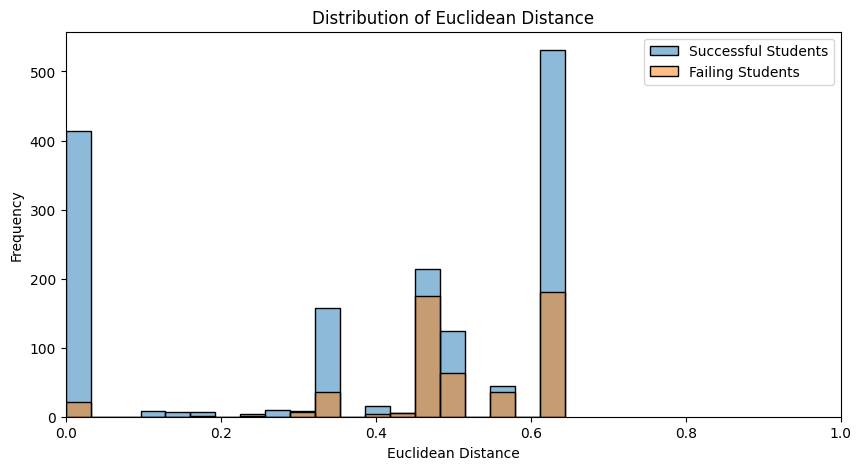

In [76]:
plt.figure(figsize=(10, 5))
sns.histplot(data_success['euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_fail['euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

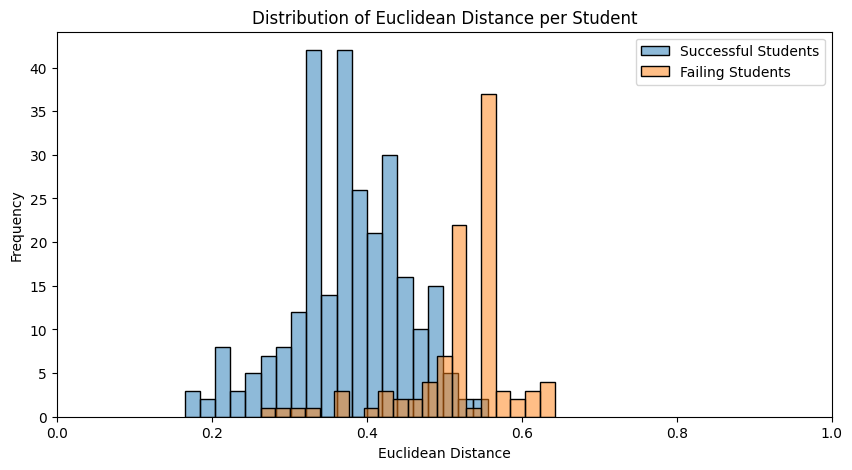

In [77]:
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['mean_euclidean_distance'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['mean_euclidean_distance'], bins=20, label='Failing Students', alpha=0.5)
plt.xlim(0, 1)
plt.xlabel('Euclidean Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Euclidean Distance per Student')
plt.legend()
plt.savefig(f"{folder}/euclidean_distance_per_student.png")

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


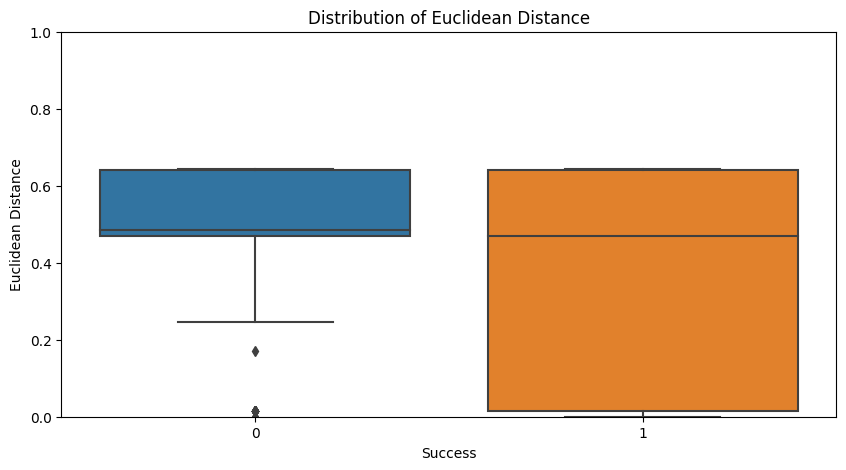

In [78]:
# Create box plots for the Euclidean distance
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='euclidean_distance', data=data)
plt.ylim(0, 1)
plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance')
plt.savefig(f"{folder}/boxplot_euclidean_distance.png")

plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


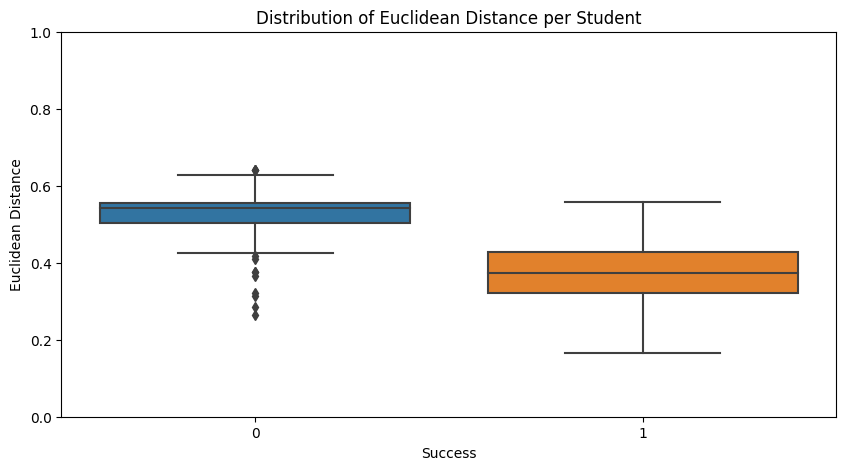

In [79]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='mean_euclidean_distance', data=data_grouped_per_student)
plt.ylim(0, 1)

plt.xlabel('Success')
plt.ylabel('Euclidean Distance')
plt.title('Distribution of Euclidean Distance per Student')

plt.savefig(f"{folder}/boxplot_euclidean_distance_per_student.png")

plt.show()

In [80]:
# Assuming 'euclidean_distance_successful' and 'euclidean_distance_failing' are arrays of Euclidean distances
statistic, p_value = mannwhitneyu(data_success['euclidean_distance'], data_fail['euclidean_distance'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of Euclidean distance (p >= 0.05)")
    


There is a significant difference between successful and failing students in terms of Euclidean distance (p < 0.05)


### Number of tentatives/runs

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

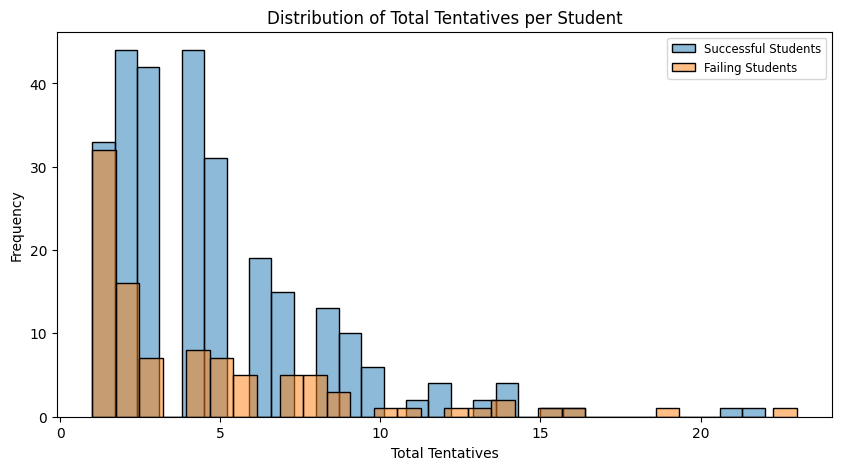

In [81]:
# Create histograms for the number of tentatives
plt.figure(figsize=(10, 5))
sns.histplot(data_grouped_per_student_success['nb_tentative'], bins=30, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['nb_tentative'], bins=30, label='Failing Students', alpha=0.5)
plt.xlabel('Total Tentatives')
plt.ylabel('Frequency')
plt.title('Distribution of Total Tentatives per Student')
plt.legend(fontsize='small')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


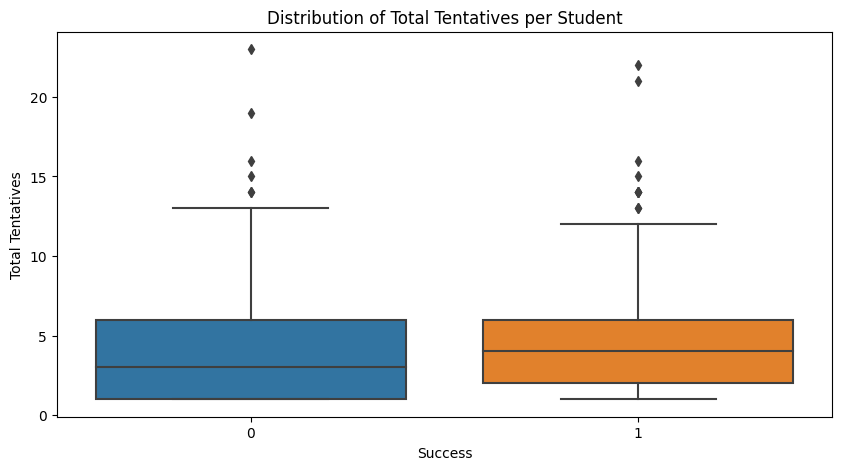

In [82]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='nb_tentative', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Total Tentatives')
plt.title('Distribution of Total Tentatives per Student')

plt.savefig(f"{folder}/boxplot_nb_tentatives_per_student.png")
plt.show()

In [83]:
# Assuming 'tentatives_successful' and 'tentatives_failing' are arrays of number of tentatives
statistic, p_value = mannwhitneyu(data_grouped_per_student_success['nb_tentative'], data_grouped_per_student_fail['nb_tentative'])

# Interpret the results
if p_value < 0.05:
    print("There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)")
else:
    print("There is no significant difference between successful and failing students in terms of number of tentatives (p >= 0.05)")


There is a significant difference between successful and failing students in terms of number of tentatives (p < 0.05)


### Observe the number of errors per students 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: Futur

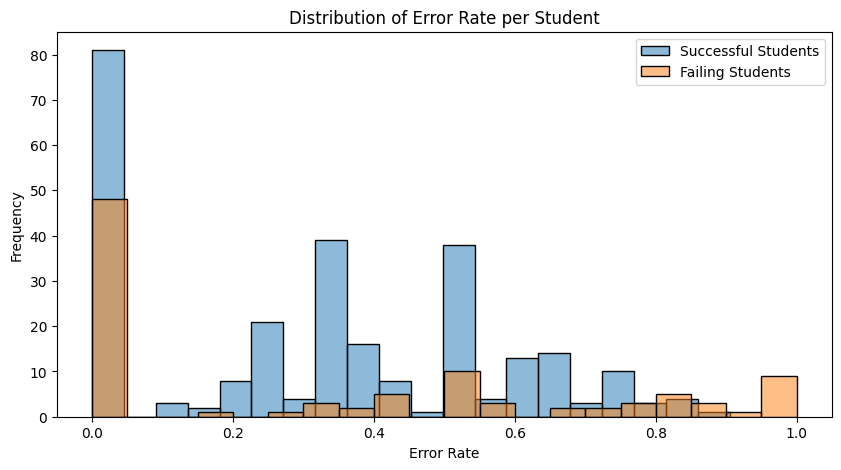

In [84]:
# plot distribution of percentage of error
plt.figure(figsize=(10, 5))

sns.histplot(data_grouped_per_student_success['pct_error'], bins=20, label='Successful Students', alpha=0.5)
sns.histplot(data_grouped_per_student_fail['pct_error'], bins=20, label='Failing Students', alpha=0.5)
plt.xlabel('Error Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Error Rate per Student')
plt.legend()

plt.savefig(f"{folder}/error_rate_per_student.png")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


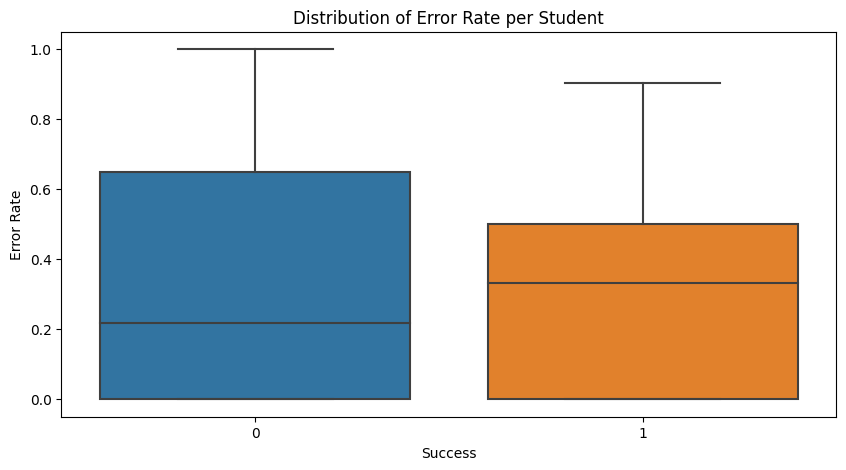

In [85]:
# Create box plots for the number of tentatives
plt.figure(figsize=(10, 5))
sns.boxplot(x='success', y='pct_error', data=data_grouped_per_student)

plt.xlabel('Success')
plt.ylabel('Error Rate')
plt.title('Distribution of Error Rate per Student')

plt.savefig(f"{folder}/boxplot_error_rate_per_student.png")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


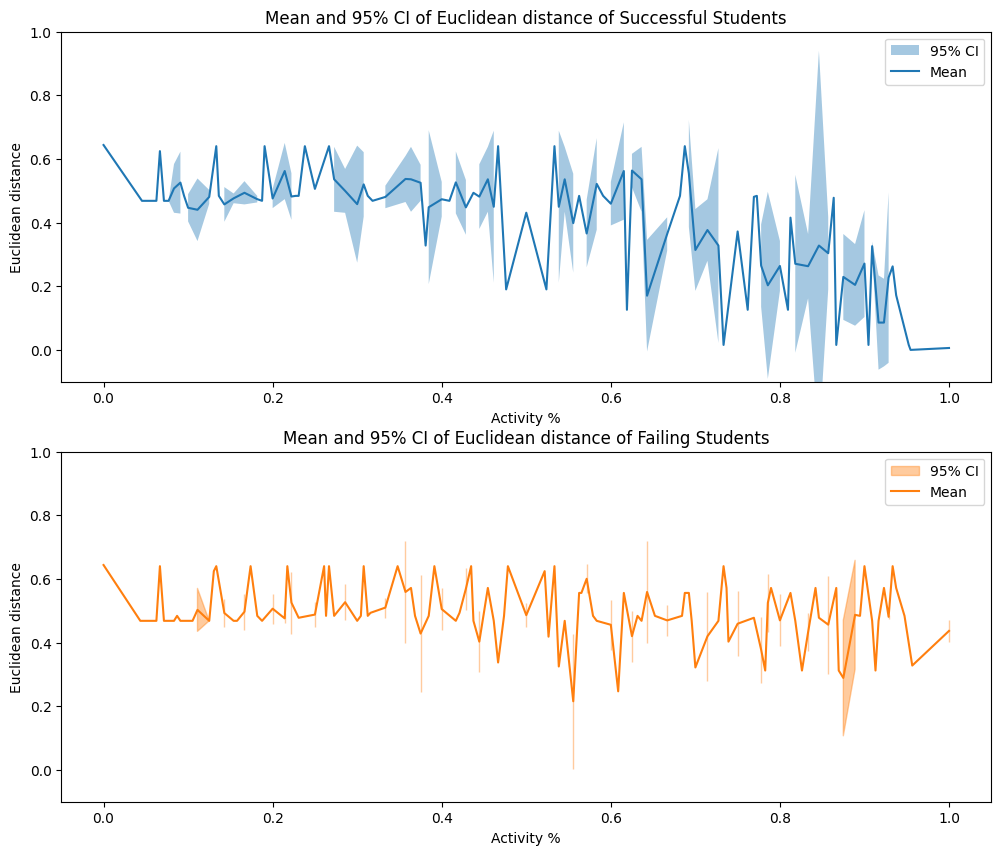

In [86]:
# plot one figure
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

grouped_success = data_success.groupby("pct_activity")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars_success = grouped_success["euclidean_distance"].mean()
ci_values_bars_success = grouped_success["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax[0].fill_between(mean_values_bars_success.index, mean_values_bars_success - ci_values_bars_success, mean_values_bars_success + ci_values_bars_success, alpha=0.4, label="95% CI")

ax[0].plot(mean_values_bars_success.index, mean_values_bars_success, linestyle='-', label="Mean")
ax[0].set_ylim(-0.1, 1)
ax[0].set_xlabel("Activity %")
ax[0].set_ylabel("Euclidean distance")
ax[0].set_title("Mean and 95% CI of Euclidean distance of Successful Students")
ax[0].legend()

grouped_fail = data_fail.groupby("pct_activity")

# Calculate mean and 95% CI for "Jaro bars" metric
mean_values_bars_fail = grouped_fail["euclidean_distance"].mean()
ci_values_bars_fail = grouped_fail["euclidean_distance"].apply(lambda x: stats.sem(x, nan_policy='omit') * 1.96)  # 95% CI

# Fill between upper and lower CI
ax[1].fill_between(mean_values_bars_fail.index, mean_values_bars_fail - ci_values_bars_fail, mean_values_bars_fail + ci_values_bars_fail, alpha=0.4, color= '#ff7f0e', label="95% CI")

ax[1].plot(mean_values_bars_fail.index, mean_values_bars_fail, linestyle='-', color= '#ff7f0e', label="Mean")
ax[1].set_ylim(-0.1, 1)
ax[1].set_xlabel("Activity %")
ax[1].set_ylabel("Euclidean distance")
ax[1].set_title("Mean and 95% CI of Euclidean distance of Failing Students")
ax[1].legend()

plt.show()

In [87]:
data_success_filtered = data_success[data_success['nb_tentative'] <= 10]
data_fail_filtered = data_fail[data_fail['nb_tentative'] <= 10]

nb_student_success_filtered = len(data_success_filtered['Student ID'].unique())
nb_student_fail_filtered = len(data_fail_filtered['Student ID'].unique())

print(f"Number of successful students after filtering: {nb_student_success_filtered}")
print(f"Number of failing students after filtering: {nb_student_fail_filtered}")

print(f"Number of rows in successful students dataset after filtering: {data_success_filtered.shape[0]}")
print(f"Number of rows in failing students dataset after filtering: {data_fail_filtered.shape[0]}")

Number of successful students after filtering: 257
Number of failing students after filtering: 89
Number of rows in successful students dataset after filtering: 1308
Number of rows in failing students dataset after filtering: 383


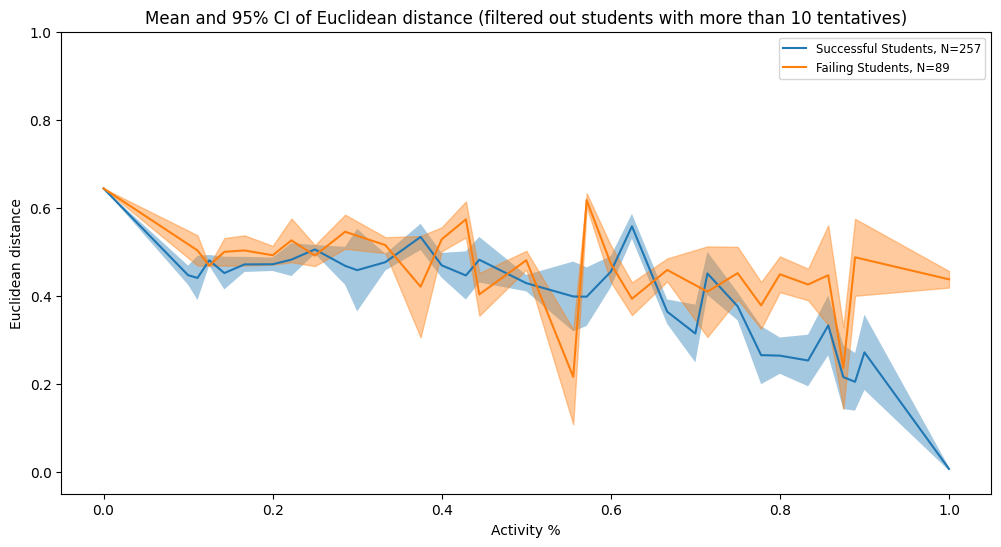

In [88]:
grouped_success = data_success_filtered.groupby("pct_activity").agg({"euclidean_distance": ["mean", "sem"], "Student ID": "count"})
grouped_success.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_success = grouped_success.dropna(subset=["euclidean_distance_mean", "euclidean_distance_sem"])

grouped_success['ci_value'] = grouped_success["euclidean_distance_sem"] * 1.96

grouped_fail = data_fail_filtered.groupby("pct_activity").agg({"euclidean_distance": ["mean", "sem"], "Student ID": "count"})
grouped_fail.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

# drop rows where euclidean_distance_mean is NaN
grouped_fail = grouped_fail.dropna(subset=["euclidean_distance_mean", "euclidean_distance_sem"])

grouped_fail['ci_value'] = grouped_fail["euclidean_distance_sem"] * 1.96


# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_mean'] - grouped_success['euclidean_distance_sem'], grouped_success["euclidean_distance_mean"] + grouped_success['euclidean_distance_sem'], alpha=0.4)
ax.plot(grouped_success.index, grouped_success['euclidean_distance_mean'], linestyle='-', label=f"Successful Students, N={nb_student_success_filtered}")

ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_mean'] - grouped_fail['euclidean_distance_sem'], grouped_fail["euclidean_distance_mean"] + grouped_fail['euclidean_distance_sem'], color= '#ff7f0e', alpha=0.4)
ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_mean'], color= '#ff7f0e', linestyle='-', label=f"Failing Students, N={nb_student_fail_filtered}")

# Set labels and title
ax.set_xlabel("Activity %")
ax.set_ylabel("Euclidean distance")
ax.set_title("Mean and 95% CI of Euclidean distance (filtered out students with more than 10 tentatives)")
ax.legend(fontsize='small')
plt.ylim(-0.05, 1)

plt.savefig(f'{folder}/euclidean_dist_act_pct.png')
plt.show()

In [89]:
data_success_per_nb_tentative = data_success.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                          'pct_move1': ['mean', 'sem'], 'pct_move2': ['mean', 'sem'], 
                                                                          'pct_pickup1': ['mean', 'sem'], 'pct_place1': ['mean', 'sem']})
data_success_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

data_fail_per_nb_tentative = data_fail.groupby('nb_tentative').agg({"euclidean_distance": ["mean", "sem", "count"], "pct_error": ["mean", "sem"], 
                                                                    'pct_move1': ['mean', 'sem'], 'pct_move2': ['mean', 'sem'], 
                                                                    'pct_pickup1': ['mean', 'sem'], 'pct_place1': ['mean', 'sem']})
data_fail_per_nb_tentative.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count", "pct_error_mean", "pct_error_sem", "pct_move1_mean", 
                                         "pct_move1_sem", "pct_move2_mean", "pct_move2_sem", "pct_pickup1_mean", "pct_pickup1_sem", "pct_place1_mean", "pct_place1_sem"]

# fill the NaN values with 0
data_success_per_nb_tentative = data_success_per_nb_tentative.fillna(0)
data_fail_per_nb_tentative = data_fail_per_nb_tentative.fillna(0)

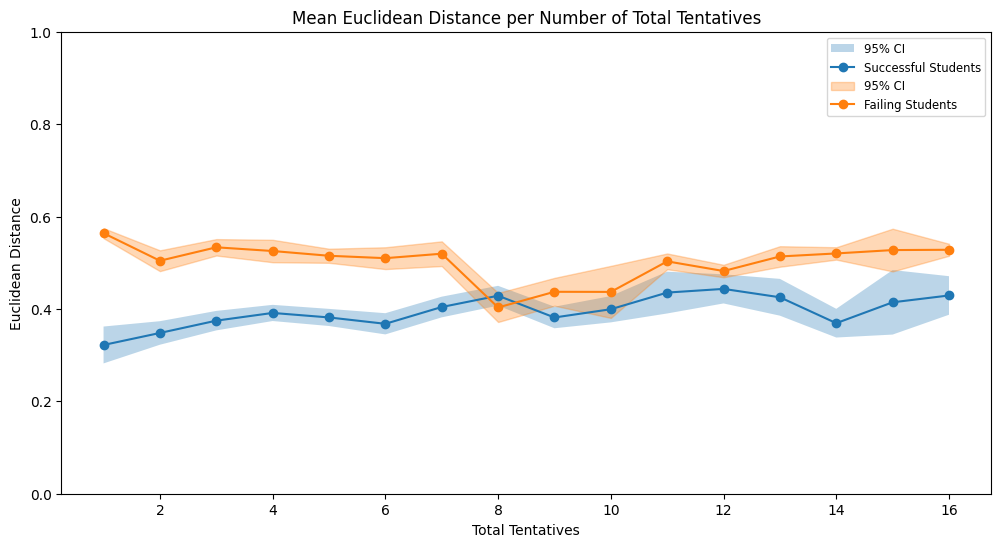

In [90]:
nb_tentative_success = data_success_per_nb_tentative.index.to_list()
nb_tentative_fail = data_fail_per_nb_tentative.index.to_list()

nb_tentative_index = set(nb_tentative_success).intersection(set(nb_tentative_fail))

data_success_per_nb_tentative = data_success_per_nb_tentative[data_success_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()
data_fail_per_nb_tentative = data_fail_per_nb_tentative[data_fail_per_nb_tentative.index.isin(nb_tentative_index)].sort_index()

# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['euclidean_distance_mean'] - data_success_per_nb_tentative['euclidean_distance_sem'], 
                data_success_per_nb_tentative["euclidean_distance_mean"] + data_success_per_nb_tentative['euclidean_distance_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['euclidean_distance_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['euclidean_distance_mean'] - data_fail_per_nb_tentative['euclidean_distance_sem'], 
                data_fail_per_nb_tentative["euclidean_distance_mean"] + data_fail_per_nb_tentative['euclidean_distance_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['euclidean_distance_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Euclidean Distance')
ax.set_title('Mean Euclidean Distance per Number of Total Tentatives')
ax.legend(fontsize='small')
plt.ylim(0, 1)

plt.savefig(f"{folder}/mean_euclidean_distance_per_nb_tentative.png")

plt.show()

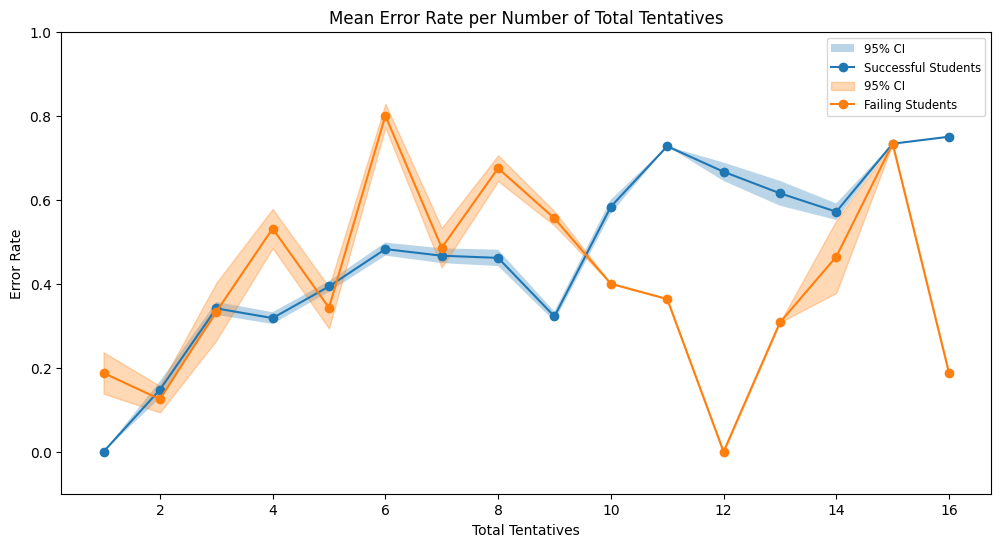

In [91]:
# plot one figure
fig, ax = plt.subplots(figsize=(12, 6))

# Plot change in Euclidean distance for successful students
ax.fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'] - data_success_per_nb_tentative['pct_error_sem'], 
                data_success_per_nb_tentative["pct_error_mean"] + data_success_per_nb_tentative['pct_error_sem'], alpha=0.3, label="95% CI")
ax.plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_error_mean'], linestyle='-', marker='o', label='Successful Students')

ax.fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'] - data_fail_per_nb_tentative['pct_error_sem'], 
                data_fail_per_nb_tentative["pct_error_mean"] + data_fail_per_nb_tentative['pct_error_sem'], color= '#ff7f0e', alpha=0.3, label="95% CI")
ax.plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_error_mean'], color= '#ff7f0e', linestyle='-', marker='o', label="Failing Students")

# Set labels and title
ax.set_xlabel('Total Tentatives')
ax.set_ylabel('Error Rate')
ax.set_title('Mean Error Rate per Number of Total Tentatives')
ax.legend(fontsize='small')
plt.ylim(-0.1, 1)
plt.savefig(f"{folder}/error_rate_per_nb_tentatives.png")
plt.show()

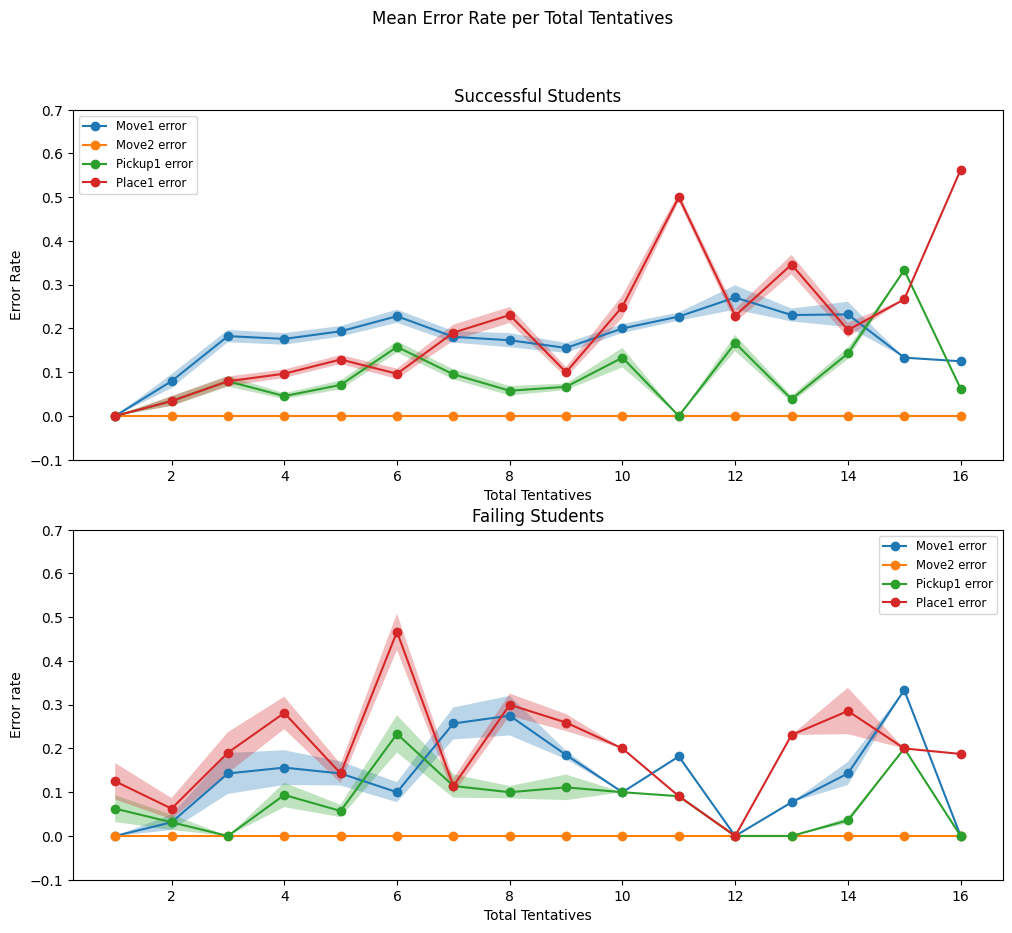

In [92]:
# plot the pct_error_move1, pct_error_move2, pct_error_pickup1, pct_error_pickup2 for Successful Students and Failing Students
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plot change in Euclidean distance for successful students
ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move1_mean'] - data_success_per_nb_tentative['pct_move1_sem'], 
                data_success_per_nb_tentative["pct_move1_mean"] + data_success_per_nb_tentative['pct_move1_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move1_mean'], linestyle='-', marker='o', label='Move1 error')

ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move2_mean'] - data_success_per_nb_tentative['pct_move2_sem'], 
                data_success_per_nb_tentative["pct_move2_mean"] + data_success_per_nb_tentative['pct_move2_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_move2_mean'], linestyle='-', marker='o', label='Move2 error')

ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_pickup1_mean'] - data_success_per_nb_tentative['pct_pickup1_sem'], 
                data_success_per_nb_tentative["pct_pickup1_mean"] + data_success_per_nb_tentative['pct_pickup1_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_pickup1_mean'], linestyle='-', marker='o', label='Pickup1 error')

ax[0].fill_between(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_place1_mean'] - data_success_per_nb_tentative['pct_place1_sem'], 
                data_success_per_nb_tentative["pct_place1_mean"] + data_success_per_nb_tentative['pct_place1_sem'], alpha=0.3)
ax[0].plot(data_success_per_nb_tentative.index, data_success_per_nb_tentative['pct_place1_mean'], linestyle='-', marker='o', label='Place1 error')

ax[0].set_ylim(-0.1, 0.7)
ax[0].set_xlabel('Total Tentatives')
ax[0].set_ylabel('Error Rate')
ax[0].set_title('Successful Students')
ax[0].legend(fontsize='small')

# Plot change in Euclidean distance for failing students
ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move1_mean'] - data_fail_per_nb_tentative['pct_move1_sem'], 
                data_fail_per_nb_tentative["pct_move1_mean"] + data_fail_per_nb_tentative['pct_move1_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move1_mean'], linestyle='-', marker='o', label='Move1 error')

ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move2_mean'] - data_fail_per_nb_tentative['pct_move2_sem'], 
                data_fail_per_nb_tentative["pct_move2_mean"] + data_fail_per_nb_tentative['pct_move2_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_move2_mean'], linestyle='-', marker='o', label='Move2 error')

ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_pickup1_mean'] - data_fail_per_nb_tentative['pct_pickup1_sem'],
                data_fail_per_nb_tentative["pct_pickup1_mean"] + data_fail_per_nb_tentative['pct_pickup1_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_pickup1_mean'], linestyle='-', marker='o', label='Pickup1 error')

ax[1].fill_between(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_place1_mean'] - data_fail_per_nb_tentative['pct_place1_sem'],
                data_fail_per_nb_tentative["pct_place1_mean"] + data_fail_per_nb_tentative['pct_place1_sem'], alpha=0.3)
ax[1].plot(data_fail_per_nb_tentative.index, data_fail_per_nb_tentative['pct_place1_mean'], linestyle='-', marker='o', label='Place1 error')
ax[1].set_ylim(-0.1, 0.7)
ax[1].set_xlabel('Total Tentatives')
ax[1].set_ylabel('Error rate')
ax[1].set_title('Failing Students')
ax[1].legend(fontsize='small')


plt.suptitle("Mean Error Rate per Total Tentatives")
plt.savefig(f"{folder}/type_error_rate_per_tentative.png")
plt.show()

### Analysis of behaviors by grouping students by the number of tentatives

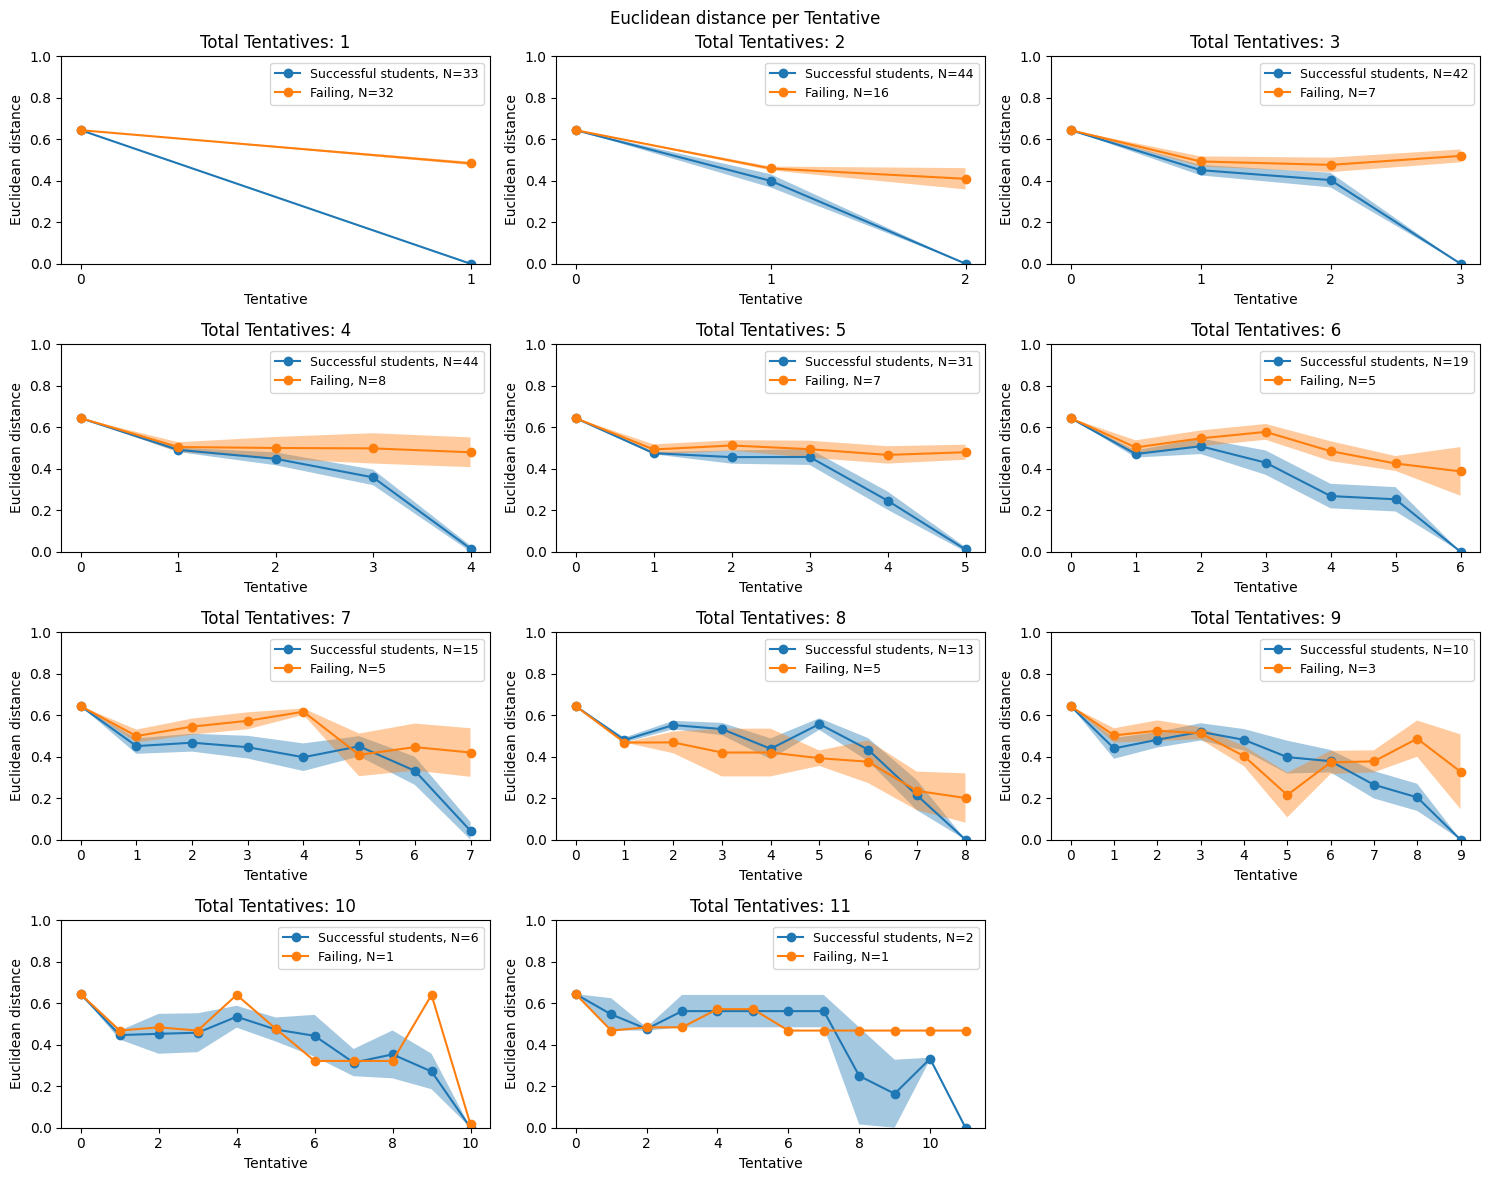

In [93]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success[data_success['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance": ["mean", "sem", "count"]})
        grouped_success.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['euclidean_distance_sem'].fillna(0, inplace=True)

        grouped_fail = data_fail[data_fail['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"euclidean_distance": ["mean", "sem", "count"]})
        grouped_fail.columns = ["euclidean_distance_mean", "euclidean_distance_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['euclidean_distance_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['euclidean_distance_mean'] - grouped_success['euclidean_distance_sem'], grouped_success["euclidean_distance_mean"] + grouped_success['euclidean_distance_sem'], alpha=0.4)
        ax.plot(grouped_success.index, grouped_success['euclidean_distance_mean'], linestyle='-', marker='o', label=f"Successful students, N={nb_success_student}")
        
        ax.fill_between(grouped_fail.index, grouped_fail['euclidean_distance_mean'] - grouped_fail['euclidean_distance_sem'], grouped_fail["euclidean_distance_mean"] + grouped_fail['euclidean_distance_sem'], alpha=0.4)
        ax.plot(grouped_fail.index, grouped_fail['euclidean_distance_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}")
        ax.set_ylim(0, 1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.legend(loc='upper right', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance per Tentative")
plt.tight_layout()
plt.savefig(f"{folder}/euclidean_distance_per_tentative_multi.png")
plt.show()

# Analysis of the difference between the successive runs

In [94]:
data_success_deltas = data_success[['Student ID', 'nb_tentative', 'index', 'delta', 'error', 'pct_activity']]
data_failing_deltas = data_fail[['Student ID', 'nb_tentative', 'index', 'delta', 'error', 'pct_activity']]

# group by Student ID and sort by index
data_success_deltas = data_success_deltas.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)
data_failing_deltas = data_failing_deltas.groupby('Student ID', as_index=False).apply(lambda x: x.sort_values(by='index')).reset_index(drop=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: 

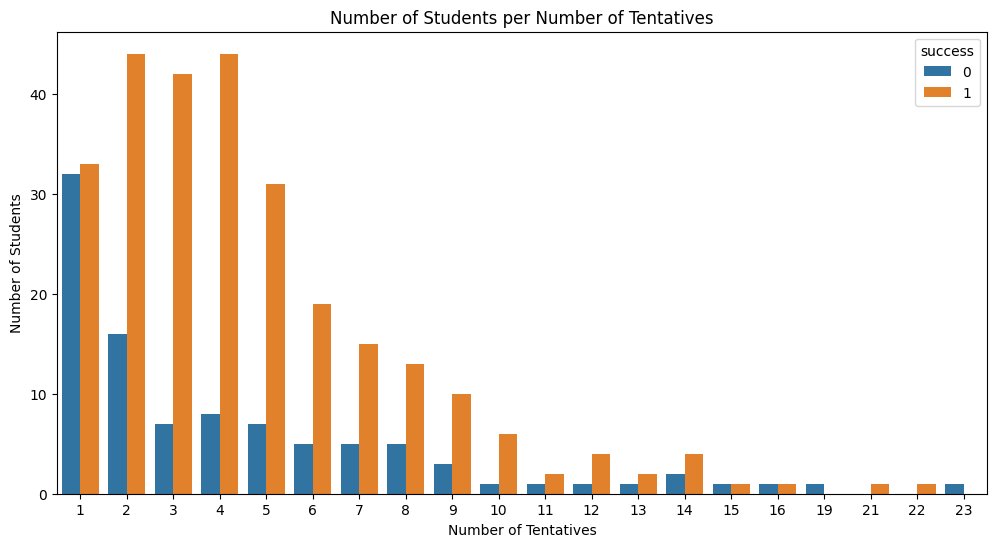

In [95]:
# bar plot of the number of students per number of tentatives
fig, ax = plt.subplots(figsize=(12, 6))

sns.countplot(x='nb_tentative', hue='success', data=data_grouped_per_student, ax=ax)

# add title and labels
ax.set_title('Number of Students per Number of Tentatives')
ax.set_xlabel('Number of Tentatives')
ax.set_ylabel('Number of Students')

plt.savefig(f'{folder}/students_per_tentatives.png')
plt.show()

## Evalutation of the difference between successive runs 

### Descriptive analysis 

In [96]:
data_success_deltas.describe()

,nb_tentative,index,delta,error,pct_activity
count,1550.000000,1550.000000,1550.000000,1550.000000,1550.000000
mean,6.677419,3.338710,-0.112349,0.349032,0.500000
std,4.378089,3.349762,0.231316,0.476818,0.350846
min,1.000000,0.000000,-0.643921,0.000000,0.000000
25%,4.000000,1.000000,-0.175400,0.000000,0.200000
50%,6.000000,2.000000,0.000000,0.000000,0.500000
75%,9.000000,5.000000,0.000000,1.000000,0.800000
max,22.000000,22.000000,0.640312,1.000000,1.000000


In [97]:
data_failing_deltas.describe()

,nb_tentative,index,delta,error,pct_activity
count,529.000000,529.000000,529.000000,529.000000,529.000000
mean,7.897921,3.948960,-0.038363,0.370510,0.500000
std,5.882126,4.249693,0.127462,0.483399,0.360388
min,1.000000,0.000000,-0.624695,0.000000,0.000000
25%,3.000000,1.000000,-0.140556,0.000000,0.166667
50%,7.000000,3.000000,0.000000,0.000000,0.500000
75%,12.000000,6.000000,0.000000,1.000000,0.833333
max,23.000000,23.000000,0.484139,1.000000,1.000000


Different type of errors: 
* move1 : cannot move, claw hit a wall 
* move 2 : collision, objects are stacked to high
* pickup1 : cannot pick up, claw is already holding an object 
* pickup2 : cannot place, claw is not holding any objet 

Should we differentiate the errors by giving a different penalty ? 

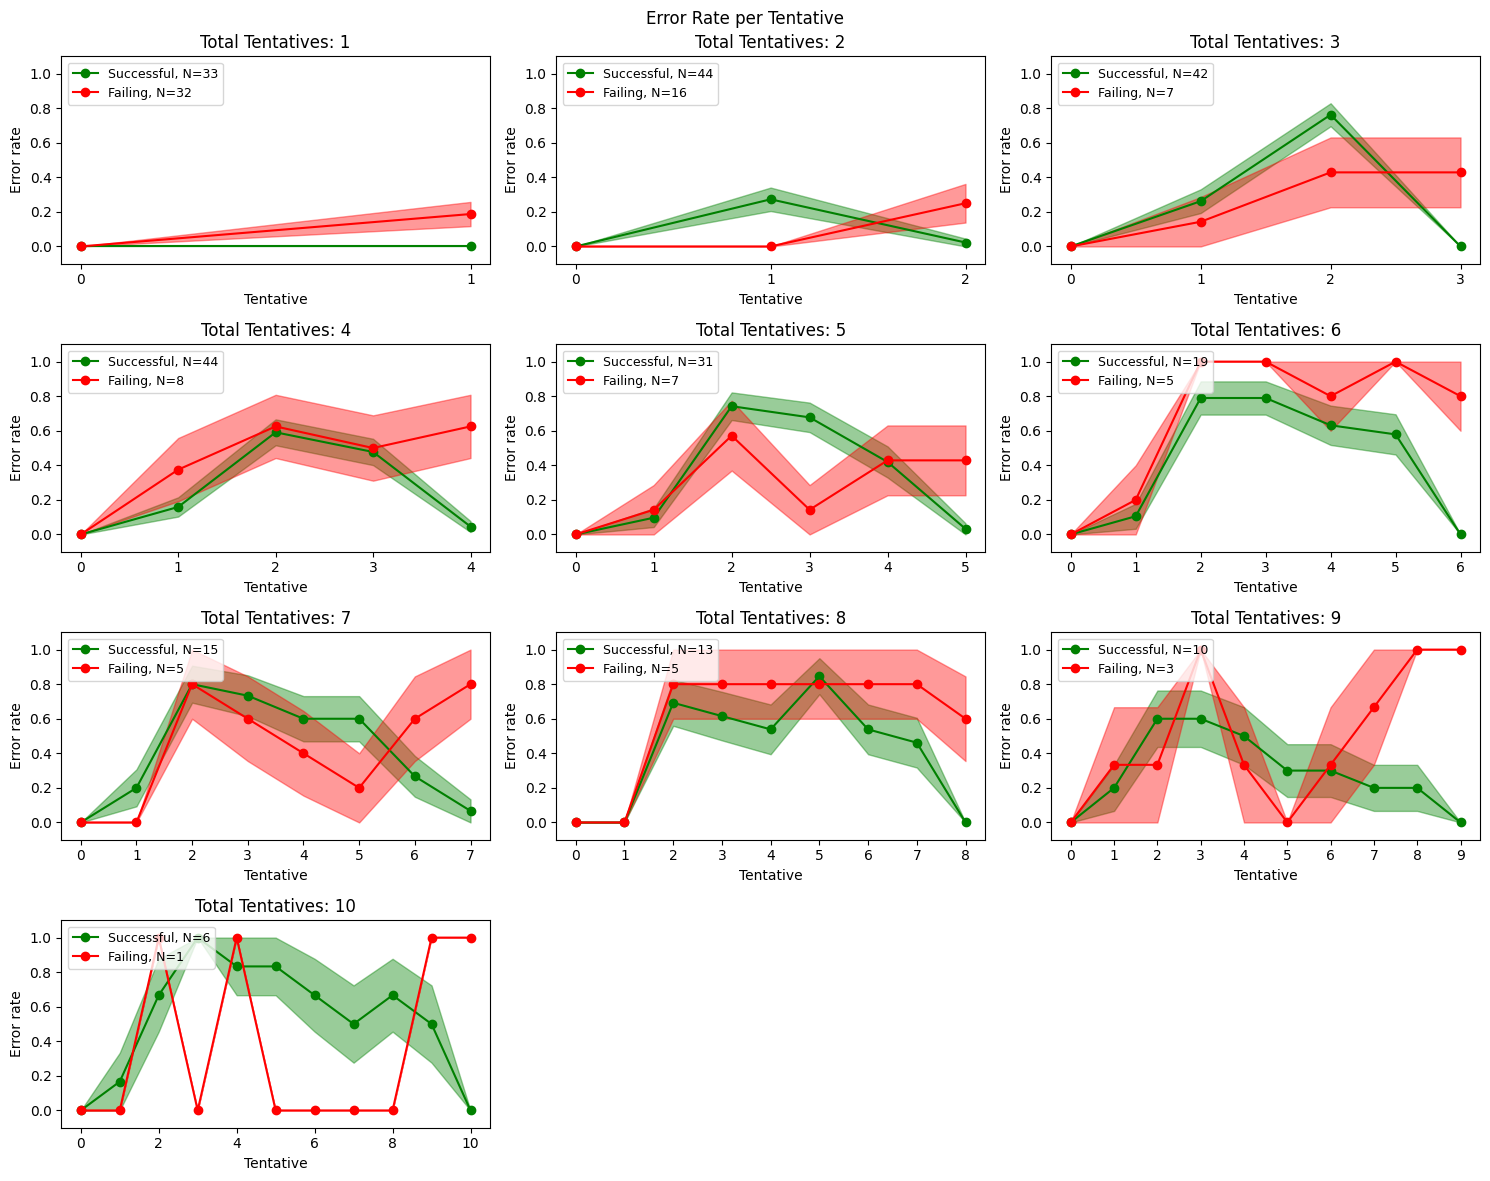

In [98]:
# create figure with 14 subplots and for each subplot, plot the mean and 95% CI of euclidean distance for the groupe of students of the same number of tentatives
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_success = data_success_deltas[data_success_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_success.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_success['error_sem'].fillna(0, inplace=True)

        grouped_fail = data_failing_deltas[data_failing_deltas['nb_tentative'] == tot_tentatives[i]].groupby("index").agg({"error": ["mean", "sem", "count"]})
        grouped_fail.columns = ["error_mean", "error_sem", "count"]

        # drop rows where euclidean_distance_mean is NaN
        grouped_fail['error_sem'].fillna(0, inplace=True)
        
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        # Fill between upper and lower CI
        ax.fill_between(grouped_success.index, grouped_success['error_mean'] - grouped_success['error_sem'], grouped_success["error_mean"] + grouped_success['error_sem'], alpha=0.4, color="green")
        ax.plot(grouped_success.index, grouped_success['error_mean'], linestyle='-', marker='o', label=f"Successful, N={nb_success_student}", color="green")
        
        ax.fill_between(grouped_fail.index, grouped_fail['error_mean'] - grouped_fail['error_sem'], grouped_fail["error_mean"] + grouped_fail['error_sem'], alpha=0.4, color="red")
        ax.plot(grouped_fail.index, grouped_fail['error_mean'], linestyle='-', marker='o', label=f"Failing, N={nb_fail_student}", color="red")
        ax.set_ylim(-0.1, 1.1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Error rate")
        ax.legend(loc='upper left', fontsize=9)
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    else:
        ax.axis('off')

plt.suptitle('Error Rate per Tentative')
plt.tight_layout()
plt.savefig(f'{folder}/error_rate_multi.png')

plt.show()

Anaylsis of the gap between successive values 

In [99]:
data.columns

Index(['Student ID', 'WorldSpace', 'index', 'nb_tentative', 'pct_activity',
       'error', 'missing', 'move1', 'move2', 'pickup1', 'place1', 'nb_error',
       'nb_missing', 'nb_move1', 'nb_move2', 'nb_pickup1', 'nb_place1',
       'pct_error', 'pct_missing', 'pct_move1', 'pct_move2', 'pct_pickup1',
       'pct_place1', 'euclidean_distance', 'delta', 'success'],
      dtype='object')

In [100]:
# drop column delta 
data = data.drop(columns='delta')

In [101]:
for idx, row in data.iterrows(): 
    if idx == 0: 
        data.loc[idx, 'delta_successive'] = 0
    else: 
        data.loc[idx, 'delta_successive'] = euclidean_v2(data.loc[idx, 'WorldSpace'], data.loc[idx-1, 'WorldSpace'], 
                                          data.loc[idx, 'move1'], data.loc[idx, 'move2'], data.loc[idx, 'place1'], 
                                          data.loc[idx, 'pickup1'], data.loc[idx, 'missing'], penalties)

Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 2
Count : 1
Count : 2
Count : 2
Count : 2
Count : 2


In [102]:
data_success = data[data['Student ID'].isin(success_students)]
data_fail = data[data['Student ID'].isin(failure_students)]

In [110]:
# filter out the students with more than 10 tentatives
data_filtered = data[data['nb_tentative'] <= 10]
data_success_filtered = data_success[data_success['nb_tentative'] <= 10]
data_fail_filtered = data_fail[data_fail['nb_tentative'] <= 10]


/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_14823/1398809140.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_filtered, y=f'delta_successive', x='pct_activity', hue="success",
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype 

Text(0.5, 1.0, 'Mean and 95% CI of Euclidean distance between successive tentatives')

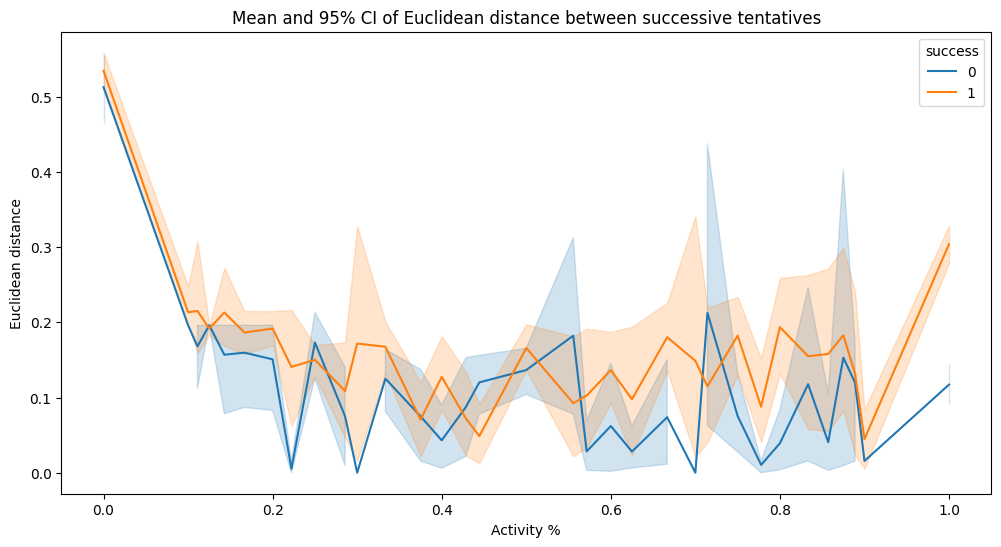

In [119]:
# change size of the figure
plt.figure(figsize=(12, 6))

sns.lineplot(data=data_filtered, y=f'delta_successive', x='pct_activity', hue="success",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95)
plt.xlabel('Activity %')
plt.ylabel('Euclidean distance')
plt.title('Mean and 95% CI of Euclidean distance between successive tentatives')

/var/folders/59/4wtmm5814rs2dj58pby6qq240000gn/T/ipykernel_14823/412610508.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=grouped_data, y=f'delta_successive', x='index', hue="success",
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is depre

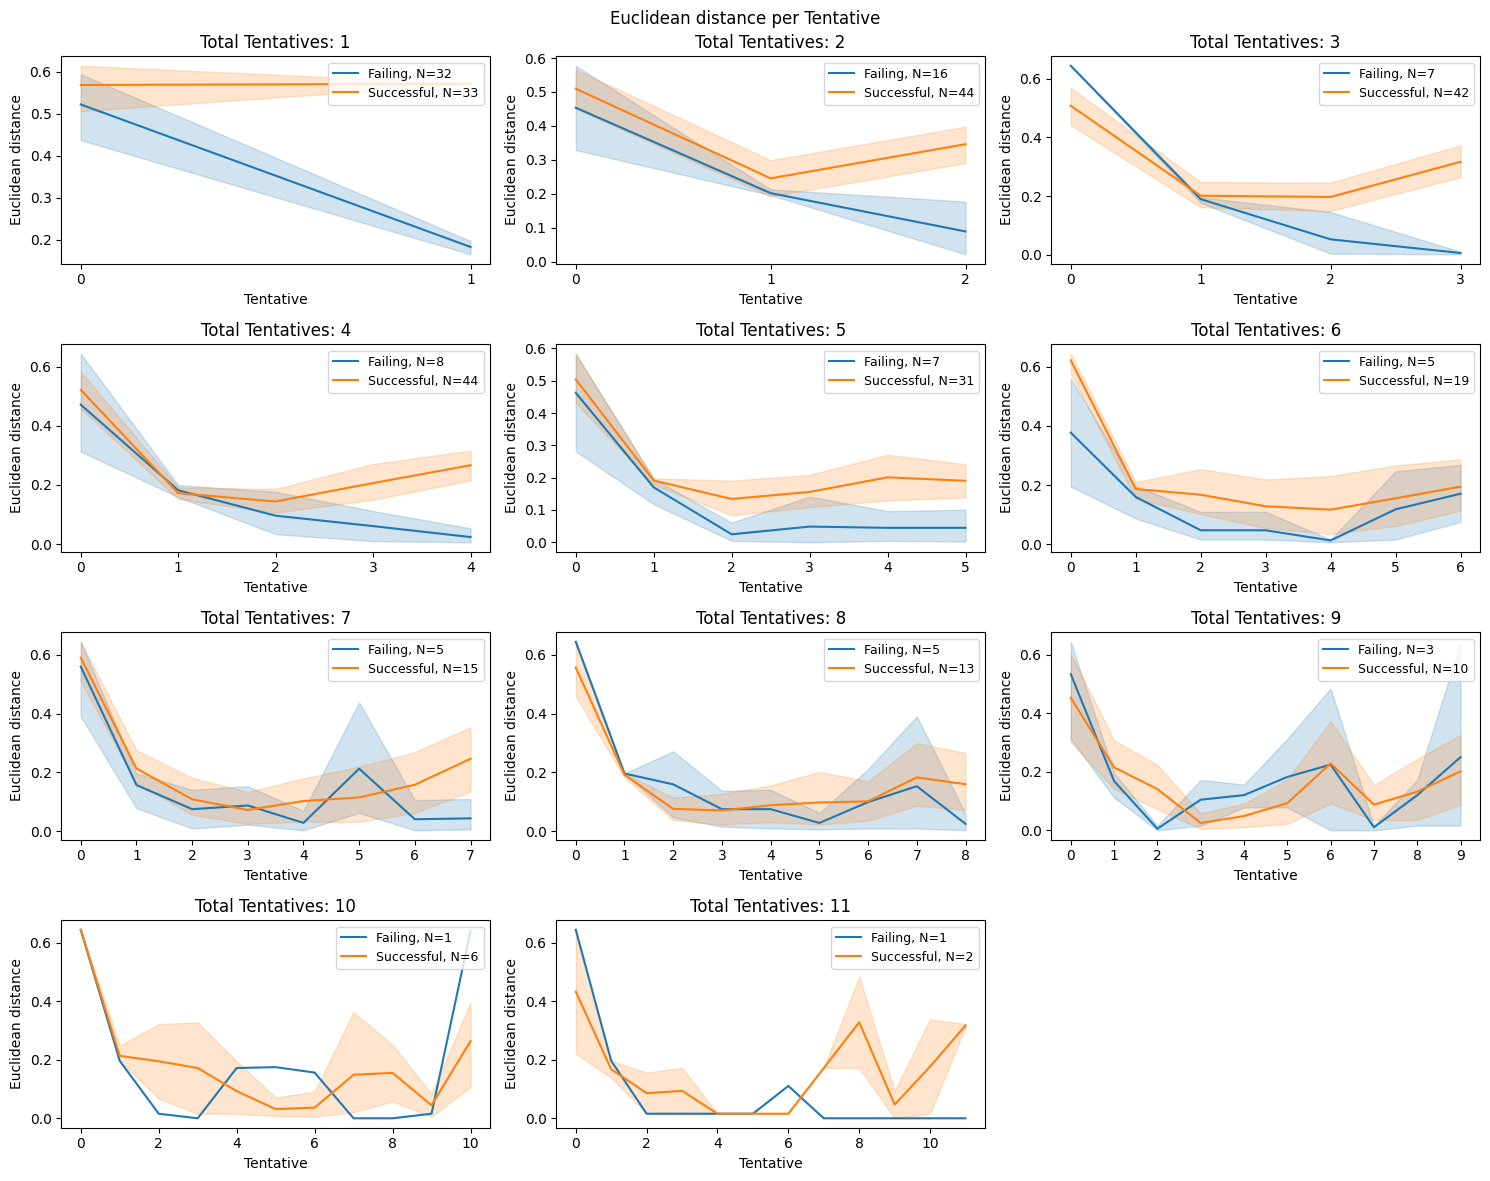

In [125]:
tot_tentatives = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

fig, axs = plt.subplots(4, 3, figsize=(15, 12))

for i, ax in enumerate(axs.flat):
    if i < len(tot_tentatives):
        grouped_data = data[data['nb_tentative'] == tot_tentatives[i]]
        
        # count number of failing and successful students
        nb_fail_student = len(data_fail[data_fail['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())
        nb_success_student = len(data_success[data_success['nb_tentative'] == tot_tentatives[i]]['Student ID'].unique())

        sns.lineplot(data=grouped_data, y=f'delta_successive', x='index', hue="success",
                     err_style="band", errorbar ='ci', estimator=np.mean, ci=95, ax=ax, legend=True)
        
        #ax.set_ylim(0, 1)
        ax.set_title(f"Total Tentatives: {tot_tentatives[i]}")
        ax.set_xlabel("Tentative")
        ax.set_ylabel("Euclidean distance")
        ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        
        handles, labels = ax.get_legend_handles_labels()
        new_labels = []
        for label in labels:
            if label == '0':
                new_labels.append(f"Failing, N={nb_fail_student}")
            else:
                new_labels.append(f"Successful, N={nb_success_student}")
        ax.legend(handles, new_labels, loc='upper right', fontsize=9)
        
    else:
        ax.axis('off')

plt.suptitle("Euclidean distance per Tentative")
plt.tight_layout()
plt.savefig(f"{folder}/euclidean_distance_per_tentative_multi.png")
plt.show()